# Teste nº 3:
### Neste notebook, verificamos os valores calculados para os coeficientes de correlação cruzada para os intervalos positivos e negativos de inclinação. Neste terceiro exemplo, utilizaremos um valor qualquer para inclinação entre 30 e 90 graus, no entanto o valor de declinação será menor que 15 graus. Vale lembrar que, para valores abaixo de 15 graus, o filtro de reduação ao Polo apresenta instabilidade numérica.

### O modelo único é um prisma retangular, com dimensões $x_i = y_i = -400$, $x_f = y_f = 400$, $z_i = 100$ e $z_f = 600$, com magnetização unitária.

### O grid para cálculo da anomalia e transformações é regular, de tamanho $-1500$ a $1500$, com número de pontos igual a $100$.

In [1]:
# IMPORTANDO OS MODULOS NECESSARIOS
import numpy as np
import matplotlib.pyplot as plt
from codes.prism import prism_tf
from codes.plot import draw_prism
from codes.auxiliars import addnoise

In [2]:
# DEFINE: NUMERO DE PONTOS, GRID, DIMENSOES DO PRISMA
n = 100
x = np.linspace(-1500, 1500, n)
y = x
z = -100.
X, Y = np.meshgrid(x, y)

model = (-400., 400., -400., 400., 100., 600., 2.0)
area = model[:4]

In [3]:
# DEFINE AS DIRECOES DE INCLINACAO E DECLINACAO
# PARA O CAMPO REGIONAL
field = (35., 35.)
# PARA A FONTE
inc_real = np.random.randint(30, 80)
dec_real = np.random.randint(8, 15)
source = (inc_real, dec_real)

In [4]:
# CALCULO DA ANOMALIA
tf = prism_tf(X, Y, z, model, source, field)

In [5]:
# IMPORTA OS MODULOS DE ESTATISTICA
from codes.statistical import analysis, cccoef

In [6]:
print 'Anomalia magnetica (sem ruido):'
_ = analysis(tf, 'nT')

Anomalia magnetica (sem ruido):
Minimum:    -225.6452 nT
Maximum:    372.6749 nT
Mean value: 2.7302 nT
Variation:  598.3201 nT


In [7]:
# ADICIONA RUIDO AO DADO
tfnoise = addnoise(tf, 5., 0.2)

In [8]:
print 'Anomalia magnetica (com ruido):'
_ = analysis(tfnoise, 'nT')

Anomalia magnetica (com ruido):
Minimum:    -220.6025 nT
Maximum:    377.6023 nT
Mean value: 7.7275 nT
Variation:  598.2047 nT


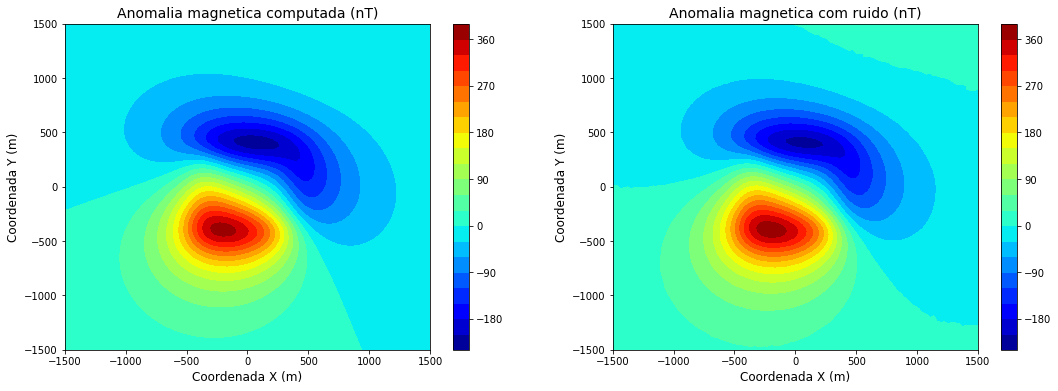

In [9]:
# PLOTA OS MAPAS DE ANOMALIA MAGNETICA
plt.close('all')
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.contourf(Y, X, tf, 20, cmap = plt.cm.jet)
#draw_prism(area, 'k--', linewidth = 1, label = 'Modelo', xy2ne = True)
plt.title('Anomalia magnetica computada (nT)' , fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 12)
plt.ylabel('Coordenada Y (m)', fontsize = 12)
plt.legend(loc = 'upper left')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(Y, X, tfnoise, 20, cmap = plt.cm.jet)
#draw_prism(area, 'k--', linewidth = 1, label = 'Modelo', xy2ne = True)
plt.title('Anomalia magnetica com ruido (nT)' , fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 12)
plt.ylabel('Coordenada Y (m)', fontsize = 12)
plt.legend(loc = 'upper left')
plt.colorbar()

plt.show()

### Para computar a correlação cruzada, escrevemos um vetor para inclinação e declinação. Para inclinação, um com valores entre 15 e 90º, e outro com valores simétricos, no caso de -90 a -15º. Para a declinação, utilizamos um intervalo de -150 a 150º.

### A correlação é aplicada entre o Gradiente Total e o Gradiente Vertical (também primeira derivada vertical) do dado magnético reduzido ao Polo. Esta redução ao Polo é feita de forma sucessiva, para cada par de inclinação e declinação da fonte magnética.

In [10]:
# DEFINE OS INTERVALOS DE INCLINAÇÃO E DECLINACAO 
# PARA O CALCULO DA CORRELACAO
inc_pos = np.arange(15, 91, 1)
inc_neg = np.arange(-90,-14, 1)
dec = np.arange(-150., 151., 1.)

# CRIAÇÃO DO GRID INC x DEC
Dec_pos, Inc_pos = np.meshgrid(dec, inc_pos)
Dec_neg, Inc_neg = np.meshgrid(dec, inc_neg)

In [11]:
# DEFINE O NUMERO DE PONTOS PARA CONSTRUIR AS MATRIZES
ni, nd = inc_pos.size, dec.size
res_pos = np.zeros([ni, nd])
res_neg = np.zeros([ni, nd])

In [12]:
from codes.filtering import reduction
from codes.derivative import totalgrad, zderiv

In [13]:
# CORRELACAO COMPUTADA PARA INTERVALO POSITIVO
for j in range(nd):
    for i in range(ni):    
        rtp_pos = reduction(x, y, tf, field, (inc_pos[i], dec[j]))
        tga_pos = totalgrad(x, y, rtp_pos)
        vga_pos = zderiv(x, y, rtp_pos)
        res_pos[i,j] = cccoef(tga_pos, vga_pos)

codes\auxiliars.py:190: RuntimeWarning: invalid value encountered in divide
  theta = z + ((x*u + y*v)/k)*1j


In [14]:
# CORRELACAO COMPUTADA PARA INTERVALO NEGATIVO
for j in range(nd):
    for i in range(ni):    
        rtp_neg = reduction(x, y, tf, field, (inc_neg[i], dec[j]))
        tga_neg = totalgrad(x, y, rtp_neg)
        vga_neg = zderiv(x, y, rtp_neg)
        res_neg[i,j] = cccoef(tga_neg, vga_neg)

In [15]:
# ANÁLISE DOS VALORES DE CORRELAÇÃO CALCULADOS
print 'Correlacao (inclinacao positiva)'
_ = analysis(res_pos)
print
print 'Correlacao (inclinacao negativa)'
_ = analysis(res_neg)

Correlacao (inclinacao positiva)
Minimum:    0.2326
Maximum:    0.6703
Mean value: 0.5359
Variation:  0.4377

Correlacao (inclinacao negativa)
Minimum:    -0.6548
Maximum:    -0.2326
Mean value: -0.5088
Variation:  0.4222


### A análise dos valores de correlação é importante para verificar se os coeficientes calculados para intervalo positivo de inclinação são iguais e simétricos aos valores calculados para o intervalo negativo.

In [16]:
# CALCULA OS INDICES ONDE A CORRELACAO É MÁXIMA E MINIMA
# INDICANDO INCLINAÇÃO E DECLINAÇÃO PARA O INTERVALO POSITVO
imax_pos, jmax_pos = np.where(res_pos == res_pos.max())
imin_pos, jmin_pos = np.where(res_pos == res_pos.min())
inc_pos_max = float(Inc_pos[imax_pos, jmax_pos])
dec_pos_max = float(Dec_pos[imax_pos, jmax_pos])

inc_pos_min = float(Inc_pos[imin_pos, jmin_pos])
dec_pos_min = float(Dec_pos[imin_pos, jmin_pos])
print 'Maxima correlacao:'
print 'Inclination:', inc_pos_max
print 'Declination:', dec_pos_max
print
print 'Minima correlacao:'
print 'Inclination:', inc_pos_min
print 'Declination:', dec_pos_min

Maxima correlacao:
Inclination: 43.0
Declination: 10.0

Minima correlacao:
Inclination: 15.0
Declination: -99.0


In [17]:
# CALCULA OS INDICES ONDE A CORRELACAO É MÁXIMA E MINIMA
# INDICANDO INCLINAÇÃO E DECLINAÇÃO PARA O INTERVALO NEGATIVO
imax_neg, jmax_neg = np.where(res_neg == res_neg.max())
imin_neg, jmin_neg = np.where(res_neg == res_neg.min())
inc_neg_max = float(Inc_neg[imax_neg, jmax_neg])
dec_neg_max = float(Dec_neg[imax_neg, jmax_neg])

inc_neg_min =float(Inc_neg[imin_neg, jmin_neg])
dec_neg_min = float(Dec_neg[imin_neg, jmin_neg])
print 'Maxima correlacao:'
print 'Inclination:', inc_neg_max
print 'Declination:', dec_neg_max
print
print 'Minima correlacao:'
print 'Inclination:', inc_neg_min
print 'Declination:', dec_neg_min

Maxima correlacao:
Inclination: -15.0
Declination: 81.0

Minima correlacao:
Inclination: -44.0
Declination: -150.0


In [18]:
# IMPRIME OS VALORES REAIS DE INCLINAÇÃO E DECLINAÇÃO
print 'Inclinacao verdadeira:', inc_real
print 'Declinacao verdadeira:', dec_real

Inclinacao verdadeira: 43
Declinacao verdadeira: 12


C:\Users\nelso\Anaconda2\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


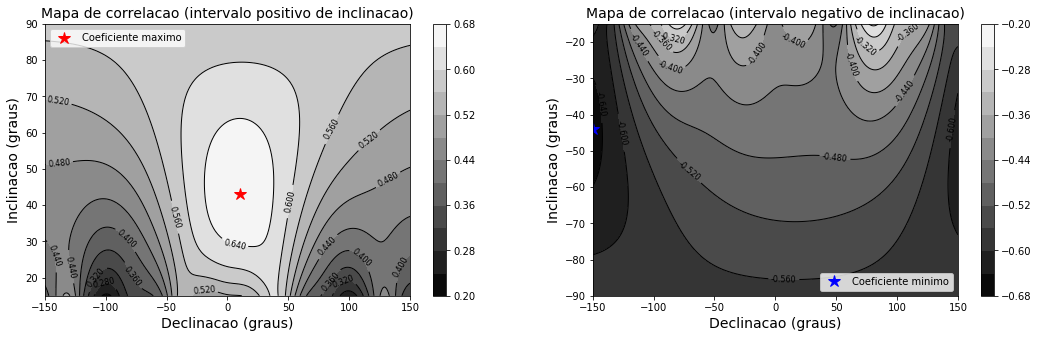

In [19]:
# Plotting the first result
plt.close('all')
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plot1 = plt.contour(Dec_pos, Inc_pos, res_pos, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.contourf(Dec_pos, Inc_pos, res_pos, 10, cmap = plt.cm.gray)
plt.plot(dec_pos_max, inc_pos_max, 'r*', markersize = 12, label = 'Coeficiente maximo')
#plt.plot(dec_pos_min, inc_pos_min, 'bs', markersize = 8, label = '(I, D) min coef')
plt.clabel(plot1, fontsize = 8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Mapa de correlacao (intervalo positivo de inclinacao)', fontsize = 14)
plt.xlabel('Declinacao (graus)', fontsize = 14)
plt.ylabel('Inclinacao (graus)', fontsize = 14)
plt.colorbar()
plt.legend(loc = 'upper left')

plt.subplot(1, 2, 2)
plot2 = plt.contour(Dec_neg, Inc_neg, res_neg, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.contourf(Dec_neg, Inc_neg, res_neg, 10, cmap = plt.cm.gray)
#plt.plot(dec_neg_max, inc_neg_max, 'ro', markersize = 8, label = '(I, D) max coef')
plt.plot(dec_neg_min, inc_neg_min, 'b*', markersize = 12, label = 'Coeficiente minimo')
plt.clabel(plot2, fontsize = 8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Mapa de correlacao (intervalo negativo de inclinacao)', fontsize = 14)
plt.xlabel('Declinacao (graus)', fontsize = 14)
plt.ylabel('Inclinacao (graus)', fontsize = 14)
plt.colorbar()
plt.legend(loc = 'lower right')

plt.show()

In [20]:
# CÁLCULO DA REDUÇÃO AO POLO PARA OS VALORES DE INCLINAÇÃO E DECLINAÇÃO
rtp_pos1 = reduction(x, y, tf, field, (inc_pos_max, dec_pos_max))
rtp_pos2 = reduction(x, y, tf, field, (inc_pos_min, dec_pos_min))
rtp_neg1 = reduction(x, y, tf, field, (inc_neg_max, dec_neg_max))
rtp_neg2 = reduction(x, y, tf, field, (inc_neg_min, dec_neg_min))

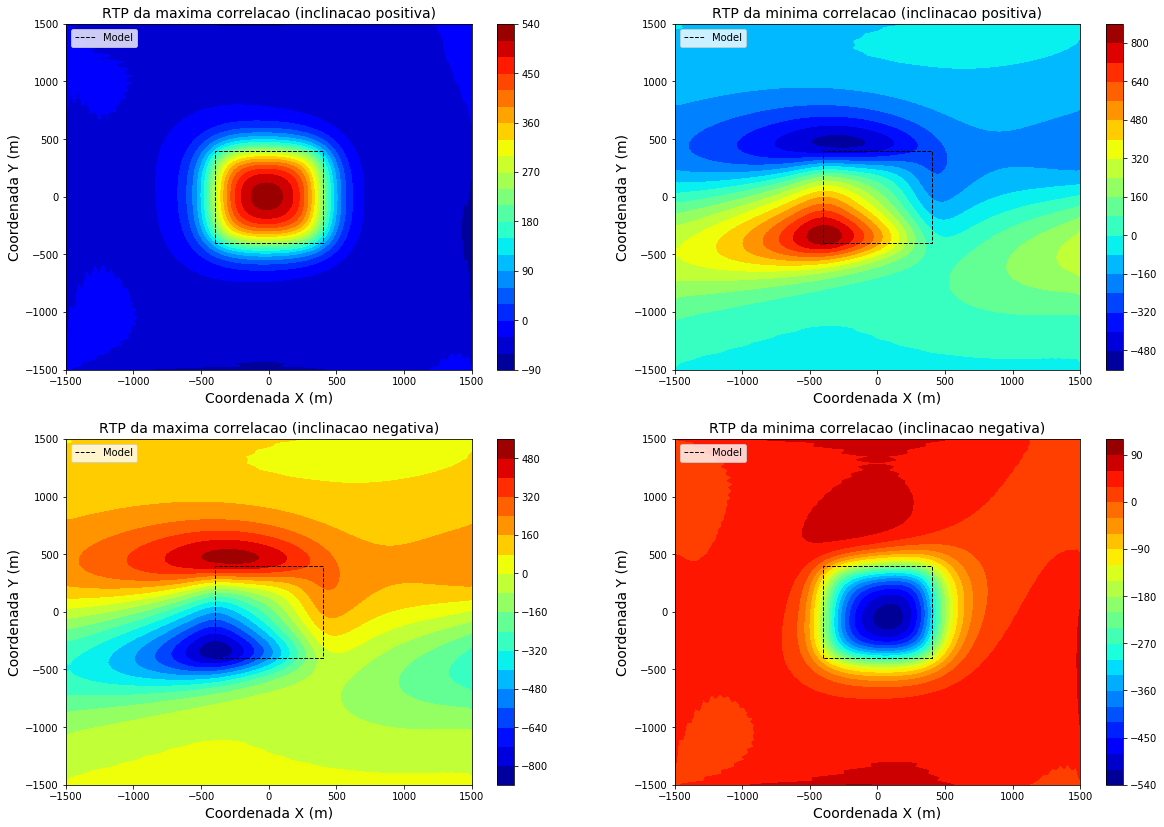

In [21]:
plt.close('all')
plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
plt.contourf(Y, X, rtp_pos1, 20, cmap = plt.cm.jet)
draw_prism(area, 'k--', linewidth = 1, label = 'Model', xy2ne = True)
plt.title('RTP da maxima correlacao (inclinacao positiva)', fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 14)
plt.ylabel('Coordenada Y (m)', fontsize = 14)
plt.legend(loc = 2)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(Y, X, rtp_pos2, 20, cmap = plt.cm.jet)
draw_prism(area, 'k--', linewidth = 1, label = 'Model', xy2ne = True)
plt.title('RTP da minima correlacao (inclinacao positiva)', fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 14)
plt.ylabel('Coordenada Y (m)', fontsize = 14)
plt.legend(loc = 2)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.contourf(Y, X, rtp_neg1, 20, cmap = plt.cm.jet)
draw_prism(area, 'k--', linewidth = 1, label = 'Model', xy2ne = True)
plt.title('RTP da maxima correlacao (inclinacao negativa)', fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 14)
plt.ylabel('Coordenada Y (m)', fontsize = 14)
plt.legend(loc = 2)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(Y, X, rtp_neg2, 20, cmap = plt.cm.jet)
draw_prism(area, 'k--', linewidth = 1, label = 'Model', xy2ne = True)
plt.title('RTP da minima correlacao (inclinacao negativa)', fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 14)
plt.ylabel('Coordenada Y (m)', fontsize = 14)
plt.legend(loc = 2)
plt.colorbar()

plt.show()

### Repetimos o procedimento do cálculo dos coeficientes de correlação para o dado com adição de ruído, a fim de verificar a variação ocorrida.

In [22]:
# DEFINE O NUMERO DE PONTOS PARA CONSTRUIR AS MATRIZES
ni, nd = inc_pos.size, dec.size
res_pos = np.zeros([ni, nd])
res_neg = np.zeros([ni, nd])

In [23]:
# CORRELACAO COMPUTADA PARA INTERVALO POSITIVO
for j in range(nd):
    for i in range(ni):    
        rtp_pos = reduction(x, y, tfnoise, field, (inc_pos[i], dec[j]))
        tga_pos = totalgrad(x, y, rtp_pos)
        vga_pos = zderiv(x, y, rtp_pos)
        res_pos[i,j] = cccoef(tga_pos, vga_pos)

In [24]:
# CORRELACAO COMPUTADA PARA INTERVALO NEGATIVO
for j in range(nd):
    for i in range(ni):    
        rtp_neg = reduction(x, y, tfnoise, field, (inc_neg[i], dec[j]))
        tga_neg = totalgrad(x, y, rtp_neg)
        vga_neg = zderiv(x, y, rtp_neg)
        res_neg[i,j] = cccoef(tga_neg, vga_neg)

In [25]:
# ANÁLISE DOS VALORES DE CORRELAÇÃO CALCULADOS
print 'Correlacao (inclinacao positiva)'
_ = analysis(res_pos)
print
print 'Correlacao (inclinacao negativa)'
_ = analysis(res_neg)

Correlacao (inclinacao positiva)
Minimum:    0.2319
Maximum:    0.6686
Mean value: 0.5349
Variation:  0.4368

Correlacao (inclinacao negativa)
Minimum:    -0.6535
Maximum:    -0.2319
Mean value: -0.5079
Variation:  0.4216


In [26]:
# CALCULA OS INDICES ONDE A CORRELACAO É MÁXIMA E MINIMA
# INDICANDO INCLINAÇÃO E DECLINAÇÃO PARA O INTERVALO POSITVO
imax_pos, jmax_pos = np.where(res_pos == res_pos.max())
imin_pos, jmin_pos = np.where(res_pos == res_pos.min())
inc_pos_max = float(Inc_pos[imax_pos, jmax_pos])
dec_pos_max = float(Dec_pos[imax_pos, jmax_pos])

inc_pos_min = float(Inc_pos[imin_pos, jmin_pos])
dec_pos_min = float(Dec_pos[imin_pos, jmin_pos])
print 'Maxima correlacao:'
print 'Inclination:', inc_pos_max
print 'Declination:', dec_pos_max
print
print 'Minima correlacao:'
print 'Inclination:', inc_pos_min
print 'Declination:', dec_pos_min

Maxima correlacao:
Inclination: 44.0
Declination: 10.0

Minima correlacao:
Inclination: 15.0
Declination: -99.0


In [28]:
# CALCULA OS INDICES ONDE A CORRELACAO É MÁXIMA E MINIMA
# INDICANDO INCLINAÇÃO E DECLINAÇÃO PARA O INTERVALO NEGATIVO
imax_neg, jmax_neg = np.where(res_neg == res_neg.max())
imin_neg, jmin_neg = np.where(res_neg == res_neg.min())
inc_neg_max = float(Inc_neg[imax_neg, jmax_neg])
dec_neg_max = float(Dec_neg[imax_neg, jmax_neg])

inc_neg_min =float(Inc_neg[imin_neg, jmin_neg])
dec_neg_min = float(Dec_neg[imin_neg, jmin_neg])
print 'Maxima correlacao:'
print 'Inclination:', inc_neg_max
print 'Declination:', dec_neg_max
print
print 'Minima correlacao:'
print 'Inclination:', inc_neg_min
print 'Declination:', dec_neg_min

Maxima correlacao:
Inclination: -15.0
Declination: 81.0

Minima correlacao:
Inclination: -44.0
Declination: -150.0


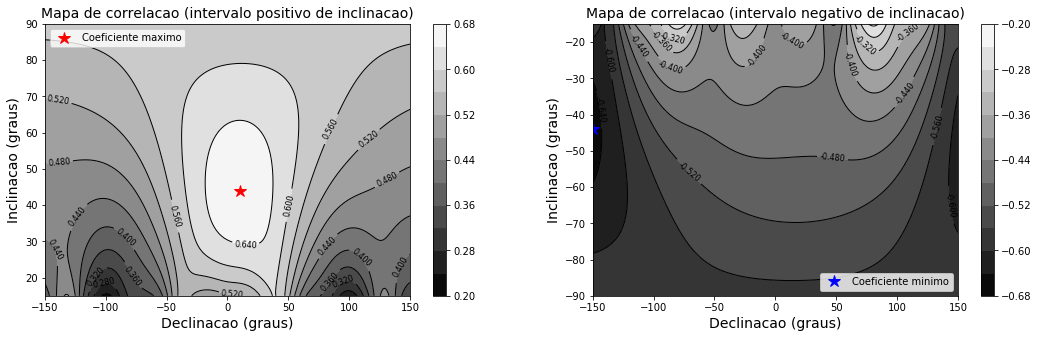

In [29]:
# Plotting the first result
plt.close('all')
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plot1 = plt.contour(Dec_pos, Inc_pos, res_pos, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.contourf(Dec_pos, Inc_pos, res_pos, 10, cmap = plt.cm.gray)
plt.plot(dec_pos_max, inc_pos_max, 'r*', markersize = 12, label = 'Coeficiente maximo')
#plt.plot(dec_pos_min, inc_pos_min, 'bs', markersize = 8, label = '(I, D) min coef')
plt.clabel(plot1, fontsize = 8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Mapa de correlacao (intervalo positivo de inclinacao)', fontsize = 14)
plt.xlabel('Declinacao (graus)', fontsize = 14)
plt.ylabel('Inclinacao (graus)', fontsize = 14)
plt.colorbar()
plt.legend(loc = 'upper left')

plt.subplot(1, 2, 2)
plot2 = plt.contour(Dec_neg, Inc_neg, res_neg, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.contourf(Dec_neg, Inc_neg, res_neg, 10, cmap = plt.cm.gray)
#plt.plot(dec_neg_max, inc_neg_max, 'ro', markersize = 8, label = '(I, D) max coef')
plt.plot(dec_neg_min, inc_neg_min, 'b*', markersize = 12, label = 'Coeficiente minimo')
plt.clabel(plot2, fontsize = 8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Mapa de correlacao (intervalo negativo de inclinacao)', fontsize = 14)
plt.xlabel('Declinacao (graus)', fontsize = 14)
plt.ylabel('Inclinacao (graus)', fontsize = 14)
plt.colorbar()
plt.legend(loc = 'lower right')

plt.show()

In [30]:
# CÁLCULO DA REDUÇÃO AO POLO PARA OS VALORES DE INCLINAÇÃO E DECLINAÇÃO
rtp_pos1 = reduction(x, y, tf, field, (inc_pos_max, dec_pos_max))
rtp_pos2 = reduction(x, y, tf, field, (inc_pos_min, dec_pos_min))
rtp_neg1 = reduction(x, y, tf, field, (inc_neg_max, dec_neg_max))
rtp_neg2 = reduction(x, y, tf, field, (inc_neg_min, dec_neg_min))

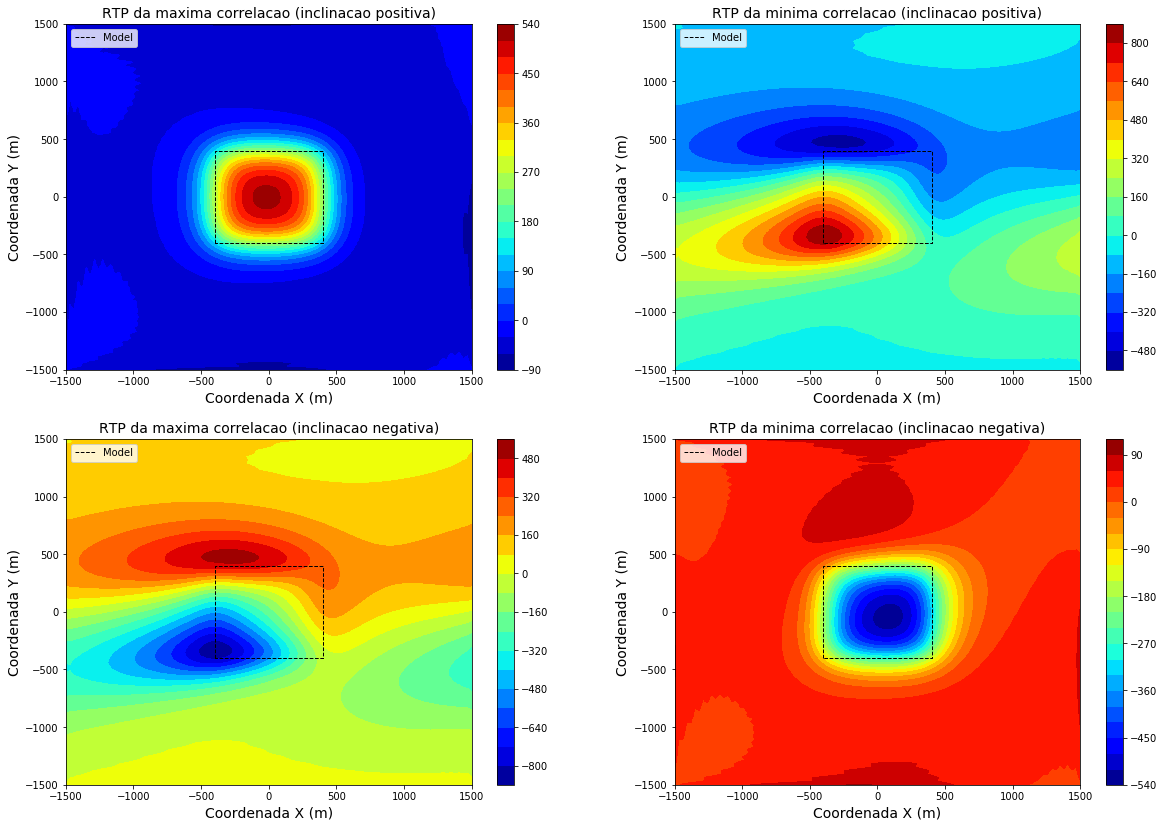

In [31]:
plt.close('all')
plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
plt.contourf(Y, X, rtp_pos1, 20, cmap = plt.cm.jet)
draw_prism(area, 'k--', linewidth = 1, label = 'Model', xy2ne = True)
plt.title('RTP da maxima correlacao (inclinacao positiva)', fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 14)
plt.ylabel('Coordenada Y (m)', fontsize = 14)
plt.legend(loc = 2)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(Y, X, rtp_pos2, 20, cmap = plt.cm.jet)
draw_prism(area, 'k--', linewidth = 1, label = 'Model', xy2ne = True)
plt.title('RTP da minima correlacao (inclinacao positiva)', fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 14)
plt.ylabel('Coordenada Y (m)', fontsize = 14)
plt.legend(loc = 2)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.contourf(Y, X, rtp_neg1, 20, cmap = plt.cm.jet)
draw_prism(area, 'k--', linewidth = 1, label = 'Model', xy2ne = True)
plt.title('RTP da maxima correlacao (inclinacao negativa)', fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 14)
plt.ylabel('Coordenada Y (m)', fontsize = 14)
plt.legend(loc = 2)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(Y, X, rtp_neg2, 20, cmap = plt.cm.jet)
draw_prism(area, 'k--', linewidth = 1, label = 'Model', xy2ne = True)
plt.title('RTP da minima correlacao (inclinacao negativa)', fontsize = 14)
plt.xlabel('Coordenada X (m)', fontsize = 14)
plt.ylabel('Coordenada Y (m)', fontsize = 14)
plt.legend(loc = 2)
plt.colorbar()

plt.show()